In [1]:
%pylab inline

from __future__ import division
from time import strftime
from calendar import monthrange
from datetime import datetime, date, timedelta
print strftime('%Y-%m-%d %X'), 'clock set'
import random
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

Populating the interactive namespace from numpy and matplotlib
2015-05-28 15:51:07 clock set


In [2]:
date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
train = pd.read_csv('../input/train.csv', parse_dates=['Date'], date_parser=date_parser)[['Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent']]
test = pd.read_csv('../input/test.csv', parse_dates=['Date'], date_parser=date_parser)[['Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy']]
print train.shape, X_test.shape

(10506, 12) (116293, 10)


In [3]:
train['Year'] = map(lambda x: x.year, train['Date'])
train['Week'] = map(lambda x: x.week, train['Date'])
train['DayOfYear'] = map(lambda x: x.timetuple().tm_yday, train['Date'])

In [4]:
X_given = train[['Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy', 'Year', 'Week', 'DayOfYear']]
y_given = train['WnvPresent']

In [5]:
def crossValidateUsingYear(train, x):
    mask_train = train['Year'] != x
    mask_validate = train['Year'] == x
    probaByWeek = train[mask_train].groupby('Week')['WnvPresent'].mean()
    z = [probaByWeek.get(i, 0) for i in train.ix[mask_validate, 'Week']]
    fpr, tpr, thresholds = roc_curve(train.ix[mask_validate, 'WnvPresent'], z)
    return fpr, tpr

AUC validating with year 2007: 0.732356880408
AUC validating with year 2009: 0.782523011565
AUC validating with year 2011: 0.699725026136
AUC validating with year 2013: 0.721322976405
Average: 0.733981973628


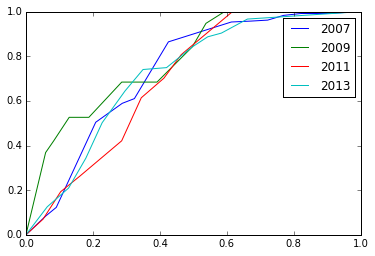

In [6]:
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
sumOfScores = 0
for year in [2007, 2009, 2011, 2013]:
    fpr, tpr = crossValidateUsingYear(train, year)
    plt.plot(fpr, tpr, label=year)
    score = auc(fpr, tpr)
    sumOfScores += score
    print 'AUC validating with year', str(year) + ':', score
print 'Average:', sumOfScores / 4
plt.legend()

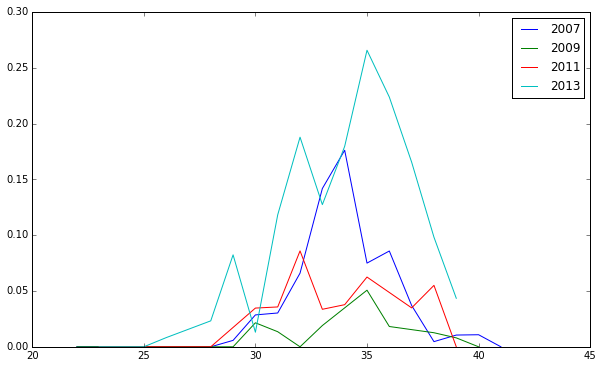

In [7]:
plt.figure(figsize=(10,6))
proba2007 = train[train['Year'] == 2007].groupby('Week')['WnvPresent'].mean()
proba2009 = train[train['Year'] == 2009].groupby('Week')['WnvPresent'].mean()
proba2011 = train[train['Year'] == 2011].groupby('Week')['WnvPresent'].mean()
proba2013 = train[train['Year'] == 2013].groupby('Week')['WnvPresent'].mean()
plt.plot(proba2007.index, proba2007, label='2007')
plt.plot(proba2009.index, proba2009, label='2009')
plt.plot(proba2011.index, proba2011, label='2011')
plt.plot(proba2013.index, proba2013, label='2013')
plt.legend()

In [22]:
probaByWeek2008 = train[train['Year'].isin([2007, 2009])].groupby('Week')['WnvPresent'].mean()
probaByWeek2010 = train[train['Year'].isin([2009, 2011])].groupby('Week')['WnvPresent'].mean()
probaByWeek2012 = train[train['Year'].isin([2011, 2013])].groupby('Week')['WnvPresent'].mean()
probaByWeek2014 = train[train['Year'].isin([2013])].groupby('Week')['WnvPresent'].mean()

with open('probaByWeek-adjacentYears.csv', 'w') as f:
    f.write('Id,WnvPresent\n')
    for i in xrange(1, 116293 + 1):
        if int(test.ix[i - 1, 'Date'].year) == 2008:
            f.write(str(i) + ',' + str(probaByWeek2008.get(test.ix[i - 1, 'Date'].week, 0)) + '\n')
        elif int(test.ix[i - 1, 'Date'].year) == 2010:
            f.write(str(i) + ',' + str(probaByWeek2010.get(test.ix[i - 1, 'Date'].week, 0)) + '\n')
        elif int(test.ix[i - 1, 'Date'].year) == 2012:
            f.write(str(i) + ',' + str(probaByWeek2012.get(test.ix[i - 1, 'Date'].week, 0)) + '\n')
        elif int(test.ix[i - 1, 'Date'].year) == 2014:
            f.write(str(i) + ',' + str(probaByWeek2014.get(test.ix[i - 1, 'Date'].week, 0)) + '\n')
        else:
            print int(test.ix[i - 1, 'Date'].year)